In [1]:
# Import packages
import pandas as pd
import numpy as np
import pickle

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score

# XGBoost
from xgboost import XGBClassifier

# Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format="retina"

## Full dataset version

In [2]:
# Load cleaned openfoodfact dataset
with open("full_data_nutri.pkl", "rb") as f:
    full = pickle.load(f)
f.close()

# Load additive feature dataset with reduced dimensions
with open("additive_feature.pkl", "rb") as f:
    x_additive = pickle.load(f)
f.close()

In [ ]:
# Keep data points from top 15 countries
country_idx = full["countries_en"].value_counts()[0:15].index.values
full = full[full["countries_en"].isin(country_idx)]

In [3]:
# Check size
full.shape

(514731, 142)

In [4]:
x_additive.shape

(514731, 120)

In [5]:
# Prepare dataset for model training
train = full.iloc[:, 15:]
train = train.drop(["pnns_groups_1", "pnns_groups_2", "nutrient_levels_tags", "main_category_en", "energy-kj_100g", "energy-kcal_100g", "main_category",
                    "nutrition-score-fr_100g", "nutrition-score-uk_100g"], axis=1)
cols = train.columns[3:].values

# Convert to numerical format and scale them
for col in cols:
    train[col] = pd.to_numeric(train[col], errors="coerce")
    train[col].fillna(0, inplace=True)
    scaler = StandardScaler()
    train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))

# Reset index
train.reset_index(drop=True, inplace=True)

In [6]:
train["nutriscore_score"] = pd.to_numeric(train["nutriscore_score"], errors="coerce")

In [ ]:
train.shape

In [7]:
# Append both dataframes into one for training
train = train.join(x_additive)

In [8]:
# Setup the dataset for training
target = train["nova_group"]
train_nova = train.drop("nova_group", axis=1)

In [9]:
# Encode nutriscore_grade into numeric index
label_encoder = LabelEncoder()
train_nova["nutriscore_grade_encoded"] = label_encoder.fit_transform(train_nova["nutriscore_grade"])
train_nova.drop("nutriscore_grade", axis=1, inplace=True)

# Fill nans with 0s
train_nova.fillna(0, inplace=True)
train_nova = np.array(train_nova)

/var/folders/9r/rp1x66b10117hbqpszsm6xhw0000gn/T/ipykernel_9575/890712444.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_nova["nutriscore_grade_encoded"] = label_encoder.fit_transform(train_nova["nutriscore_grade"])


#### Logistic Regression (Sklearn)

In [10]:
# Cross validate with K-Fold on 5 folds
k = 5

kf = KFold(n_splits=k, random_state=42, shuffle=True)

kf_lr_results = []
i = 1
for (train_index, test_index) in kf.split(train_nova):
    print(f"Fold = {i}")
    x_train = train_nova[train_index]
    x_test = train_nova[test_index]
    y_train = np.array(target)[train_index]
    y_test = np.array(target)[test_index]

    # Initialize logistic regression model
    lr = LogisticRegression(max_iter=10_000)

    # Train model
    lr.fit(x_train, y_train)
    y_hat = lr.predict(x_test)

    # Calculate accuracy
    kf_lr_results.append(accuracy_score(y_test, y_hat))

    i += 1
print(f"CV logistic regression model accuracy: {np.mean(kf_lr_results)}")

Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
CV logistic regression model accuracy: 0.7554509048847435


#### Decision Tree Classifier

In [11]:
# Cross validate with K-Fold on 5 folds
k = 5

kf = KFold(n_splits=k, random_state=42, shuffle=True)

kf_dt_results = []
i = 1
for (train_index, test_index) in kf.split(train_nova):
    print(f"Fold = {i}")
    x_train = train_nova[train_index]
    x_test = train_nova[test_index]
    y_train = np.array(target)[train_index]
    y_test = np.array(target)[test_index]

    # Initialize decision tree classifier model
    clf = DecisionTreeClassifier()

    # Train model
    clf.fit(x_train, y_train)
    y_hat = clf.predict(x_test)

    # Calculate accuracy
    kf_dt_results.append(accuracy_score(y_test, y_hat))

    i += 1

print(f"CV decision tree classifier accuracy: {np.mean(kf_dt_results)}")

Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
CV decision tree classifier accuracy: 0.8545531515083093


#### Random Forest Classifier

In [13]:
# Cross validate with K-Fold on 5 folds
k = 5

kf = KFold(n_splits=k, random_state=42, shuffle=True)

kf_rf_results = []
i = 1
for (train_index, test_index) in kf.split(train_nova):
    print(f"Fold = {i}")
    x_train = train_nova[train_index]
    x_test = train_nova[test_index]
    y_train = np.array(target)[train_index]
    y_test = np.array(target)[test_index]

    # Initialize random forest classifier model
    rf = RandomForestClassifier()

    # Train model
    rf.fit(x_train, y_train)
    y_hat = rf.predict(x_test)

    # Calculate accuracy
    kf_rf_results.append(accuracy_score(y_test, y_hat))

    i += 1

print(f"CV random forest accuracy: {np.mean(kf_rf_results)}")

Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
CV random forest accuracy: 0.893134469114267


#### XGBoost Classifier

In [12]:
# Cross validate with K-Fold on 5 folds
k = 5

kf = KFold(n_splits=k, random_state=42, shuffle=True)

kf_xgb_results = []
i = 1
for (train_index, test_index) in kf.split(train_nova):
    print(f"Fold = {i}")
    x_train = train_nova[train_index]
    x_test = train_nova[test_index]
    y_train = np.array(target).astype("int")[train_index] - 1
    y_test = np.array(target).astype("int")[test_index] - 1

    # Initialize XGBoost classifier model
    xgb = XGBClassifier()

    # Train model
    xgb.fit(x_train, y_train)
    y_hat = xgb.predict(x_test)

    # Calculate accuracy
    kf_xgb_results.append(accuracy_score(y_test, y_hat))

    i += 1

print(f"CV XGBoost classifier accuracy: {np.mean(kf_xgb_results)}")

Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
CV XGBoost classifier accuracy: 0.8549766738032563


In [14]:
# Consolidate the CV accuracy results into a dataframe
lr_accuracy = pd.DataFrame(kf_lr_results, columns=["logistic_regression"])
dt_accuracy = pd.DataFrame(kf_dt_results, columns=["decision_treee"])
rf_accuracy = pd.DataFrame(kf_rf_results, columns=["random_forest"])
xgb_accuracy = pd.DataFrame(kf_xgb_results, columns=["xgboost"])
k = pd.DataFrame([i for i in range(1, 6)], columns=["k"])

accuracy = pd.concat([lr_accuracy, dt_accuracy, rf_accuracy, xgb_accuracy, k], axis=1)

In [15]:
# Plot accuracy result of data
accuracy = accuracy.melt(id_vars="k", var_name="model", value_name="accuracy")
accuracy["accuracy"] = accuracy["accuracy"] * 100.0

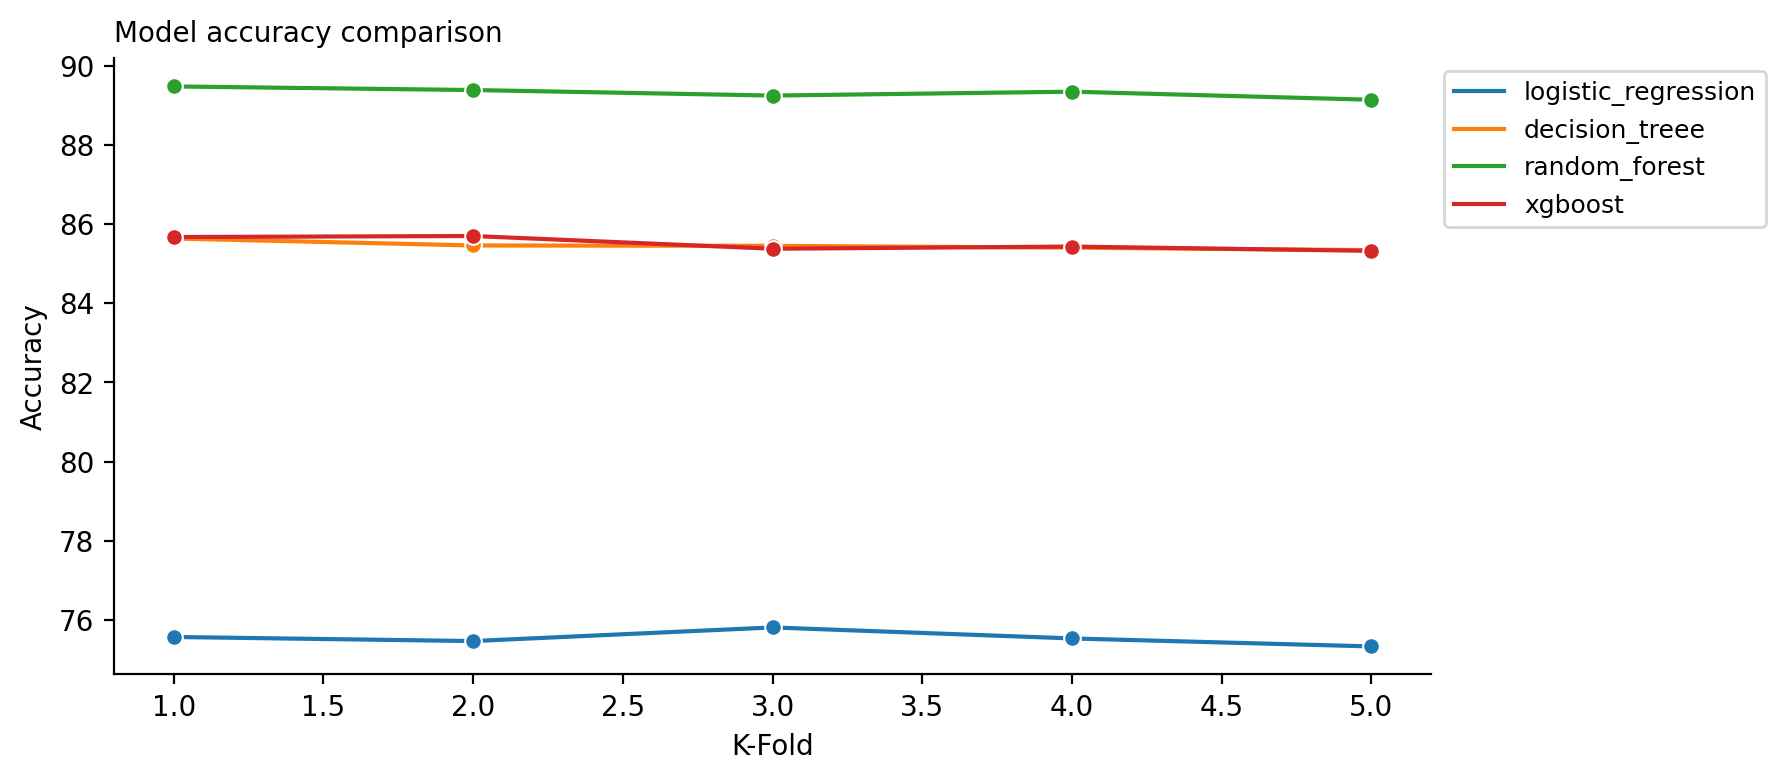

In [16]:
plt.figure(figsize=(8.5, 4))
sns.lineplot(data=accuracy, x="k", y="accuracy", hue="model", marker="o")
plt.title("Model accuracy comparison", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(fontsize=9, bbox_to_anchor=(1,1))
plt.ylabel("Accuracy")
plt.xlabel("K-Fold")
plt.show()

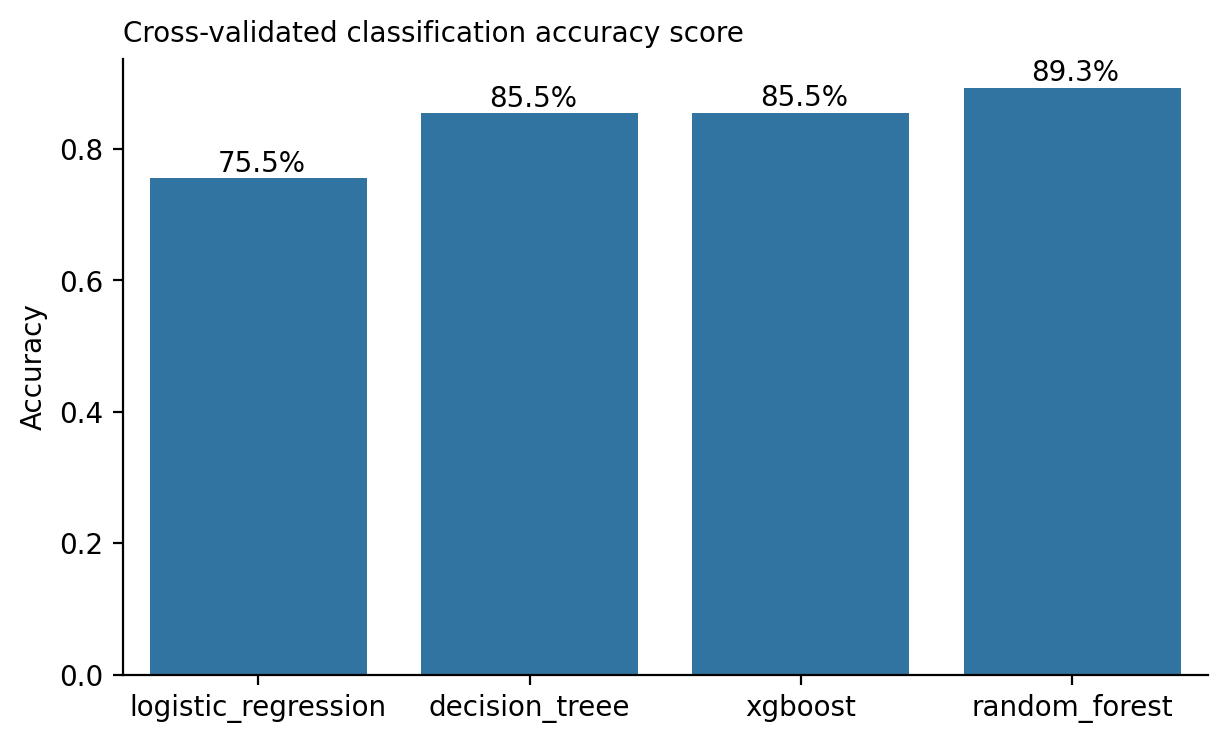

In [17]:
# Plot average CV accuracy
avg_accuracy = accuracy.groupby("model")["accuracy"].mean().reset_index()
avg_accuracy["accuracy"] = avg_accuracy["accuracy"] / 100.0
avg_accuracy.sort_values("accuracy", inplace=True)

plt.figure(figsize=(7, 4))
sns.barplot(data=avg_accuracy, x="model", y="accuracy", color="tab:blue")
plt.title("Cross-validated classification accuracy score", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.ylabel("Accuracy")
plt.xlabel("")
for i, val in enumerate(avg_accuracy["accuracy"]):
    plt.text(i-0.15, val+0.01, f"{val:.1%}", fontsize=10)

plt.show()

## Downsampled dataset version

In [30]:
# Load cleaned openfoodfact dataset
with open("downsample_data_nutri.pkl", "rb") as f:
    down = pickle.load(f)
f.close()

# Load additive feature dataset with reduced dimensions
with open("downsample_additive_feature.pkl", "rb") as f:
    x_down_additive = pickle.load(f)
f.close()

In [31]:
# Check size
down.shape

(88000, 142)

In [32]:
x_down_additive.shape

(88000, 117)

In [34]:
# Prepare dataset for model training
train = down.iloc[:, 15:]
train = train.drop(["pnns_groups_1", "pnns_groups_2", "nutrient_levels_tags", "main_category_en", "energy-kj_100g", "energy-kcal_100g", "main_category",
                    "nutrition-score-fr_100g", "nutrition-score-uk_100g"], axis=1)
cols = train.columns[3:].values

# Convert to numerical format and scale them
for col in cols:
    train[col] = pd.to_numeric(train[col], errors="coerce")
    train[col].fillna(0, inplace=True)
    scaler = StandardScaler()
    train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))

# Reset index
train.reset_index(drop=True, inplace=True)

In [35]:
train["nutriscore_score"] = pd.to_numeric(train["nutriscore_score"], errors="coerce")

In [36]:
train.shape

(88000, 118)

In [37]:
# Append both dataframes into one for training
train = train.join(x_down_additive)

In [38]:
# Setup the dataset for training
target = train["nova_group"]
train_nova = train.drop("nova_group", axis=1)

In [39]:
# Encode nutriscore_grade into numeric index
label_encoder = LabelEncoder()
train_nova["nutriscore_grade_encoded"] = label_encoder.fit_transform(train_nova["nutriscore_grade"])
train_nova.drop("nutriscore_grade", axis=1, inplace=True)

# Fill nans with 0s
train_nova.fillna(0, inplace=True)
train_nova = np.array(train_nova)

/var/folders/9r/rp1x66b10117hbqpszsm6xhw0000gn/T/ipykernel_9575/890712444.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_nova["nutriscore_grade_encoded"] = label_encoder.fit_transform(train_nova["nutriscore_grade"])


#### Logistic Regression (Sklearn)

In [40]:
# Cross validate with K-Fold on 5 folds
k = 5

kf = KFold(n_splits=k, random_state=42, shuffle=True)

kf_lr_results = []
i = 1
for (train_index, test_index) in kf.split(train_nova):
    print(f"Fold = {i}")
    x_train = train_nova[train_index]
    x_test = train_nova[test_index]
    y_train = np.array(target)[train_index]
    y_test = np.array(target)[test_index]

    # Initialize logistic regression model
    lr = LogisticRegression(max_iter=10_000)

    # Train model
    lr.fit(x_train, y_train)
    y_hat = lr.predict(x_test)

    # Calculate accuracy
    kf_lr_results.append(accuracy_score(y_test, y_hat))

    i += 1
print(f"CV logistic regression model accuracy: {np.mean(kf_lr_results)}")

Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
CV logistic regression model accuracy: 0.7998295454545454


#### Decision Tree Classifier

In [41]:
# Cross validate with K-Fold on 5 folds
k = 5

kf = KFold(n_splits=k, random_state=42, shuffle=True)

kf_dt_results = []
i = 1
for (train_index, test_index) in kf.split(train_nova):
    print(f"Fold = {i}")
    x_train = train_nova[train_index]
    x_test = train_nova[test_index]
    y_train = np.array(target)[train_index]
    y_test = np.array(target)[test_index]

    # Initialize decision tree classifier model
    clf = DecisionTreeClassifier()

    # Train model
    clf.fit(x_train, y_train)
    y_hat = clf.predict(x_test)

    # Calculate accuracy
    kf_dt_results.append(accuracy_score(y_test, y_hat))

    i += 1

print(f"CV decision tree classifier accuracy: {np.mean(kf_dt_results)}")

Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
CV decision tree classifier accuracy: 0.8411363636363636


#### Random Forest Classifier

In [42]:
# Cross validate with K-Fold on 5 folds
k = 5

kf = KFold(n_splits=k, random_state=42, shuffle=True)

kf_rf_results = []
i = 1
for (train_index, test_index) in kf.split(train_nova):
    print(f"Fold = {i}")
    x_train = train_nova[train_index]
    x_test = train_nova[test_index]
    y_train = np.array(target)[train_index]
    y_test = np.array(target)[test_index]

    # Initialize random forest classifier model
    rf = RandomForestClassifier()

    # Train model
    rf.fit(x_train, y_train)
    y_hat = rf.predict(x_test)

    # Calculate accuracy
    kf_rf_results.append(accuracy_score(y_test, y_hat))

    i += 1

print(f"CV random forest accuracy: {np.mean(kf_rf_results)}")

Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
CV random forest accuracy: 0.8858750000000001


#### XGBoost Classifier

In [43]:
# Cross validate with K-Fold on 5 folds
k = 5

kf = KFold(n_splits=k, random_state=42, shuffle=True)

kf_xgb_results = []
i = 1
for (train_index, test_index) in kf.split(train_nova):
    print(f"Fold = {i}")
    x_train = train_nova[train_index]
    x_test = train_nova[test_index]
    y_train = np.array(target).astype("int")[train_index] - 1
    y_test = np.array(target).astype("int")[test_index] - 1

    # Initialize XGBoost classifier model
    xgb = XGBClassifier()

    # Train model
    xgb.fit(x_train, y_train)
    y_hat = xgb.predict(x_test)

    # Calculate accuracy
    kf_xgb_results.append(accuracy_score(y_test, y_hat))

    i += 1

print(f"CV XGBoost classifier accuracy: {np.mean(kf_xgb_results)}")

Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
CV XGBoost classifier accuracy: 0.881443181818182


In [44]:
# Consolidate the CV accuracy results into a dataframe
down_lr_accuracy = pd.DataFrame(kf_lr_results, columns=["logistic_regression"])
down_dt_accuracy = pd.DataFrame(kf_dt_results, columns=["decision_treee"])
down_rf_accuracy = pd.DataFrame(kf_rf_results, columns=["random_forest"])
down_xgb_accuracy = pd.DataFrame(kf_xgb_results, columns=["xgboost"])
k = pd.DataFrame([i for i in range(1, 6)], columns=["k"])

down_accuracy = pd.concat([down_lr_accuracy, down_dt_accuracy, down_rf_accuracy, down_xgb_accuracy, k], axis=1)

In [45]:
# Plot accuracy result of data
down_accuracy = down_accuracy.melt(id_vars="k", var_name="model", value_name="accuracy")
down_accuracy["accuracy"] = down_accuracy["accuracy"] * 100.0

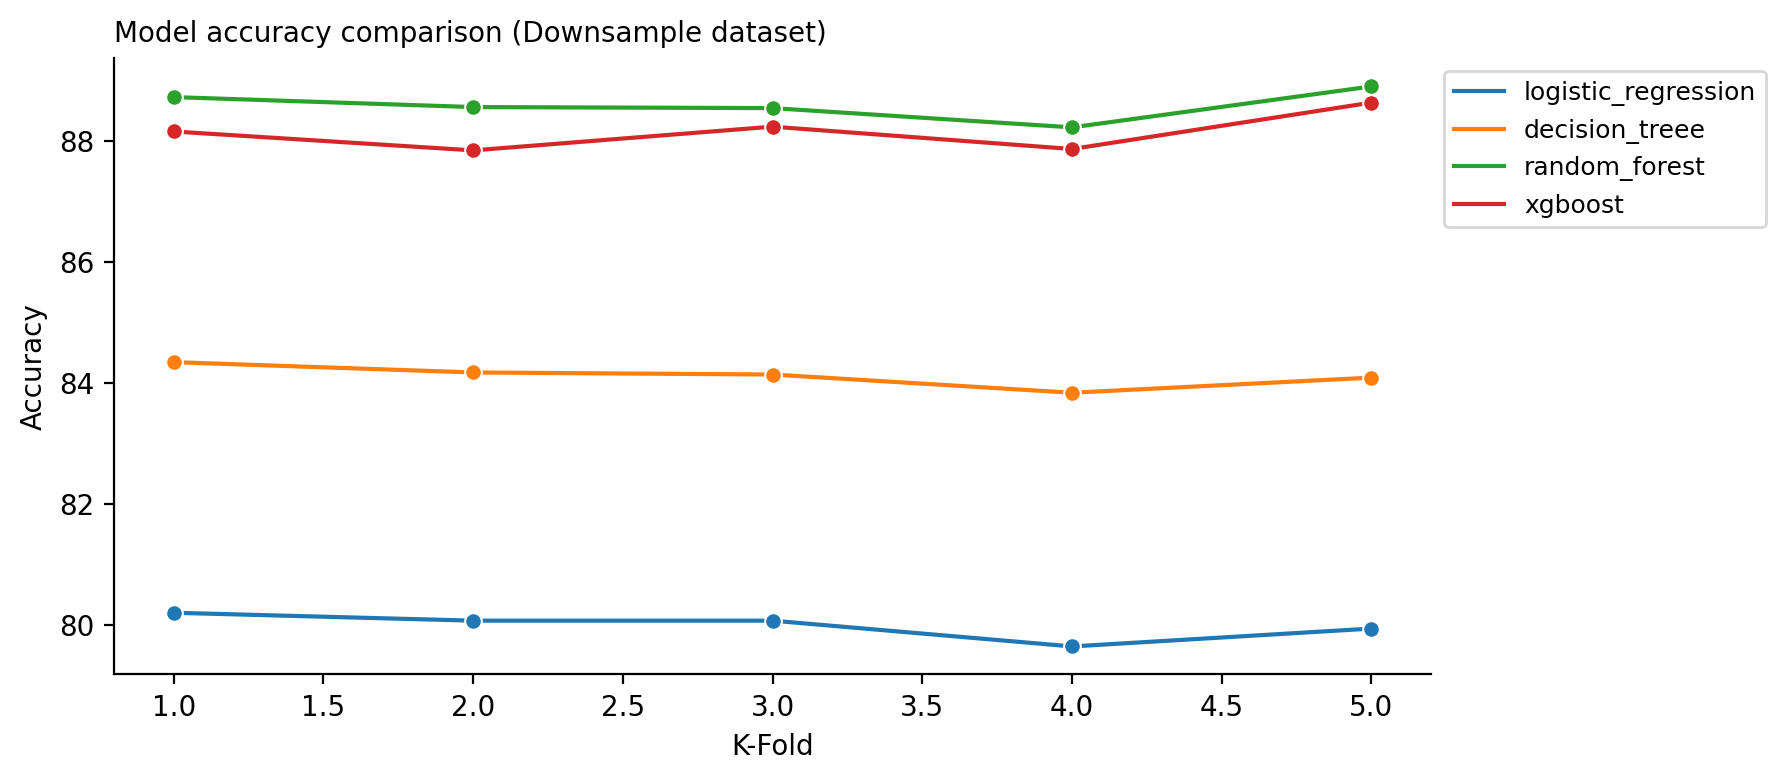

In [46]:
plt.figure(figsize=(8.5, 4))
sns.lineplot(data=down_accuracy, x="k", y="accuracy", hue="model", marker="o")
plt.title("Model accuracy comparison (Downsample dataset)", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(fontsize=9, bbox_to_anchor=(1,1))
plt.ylabel("Accuracy")
plt.xlabel("K-Fold")
plt.show()

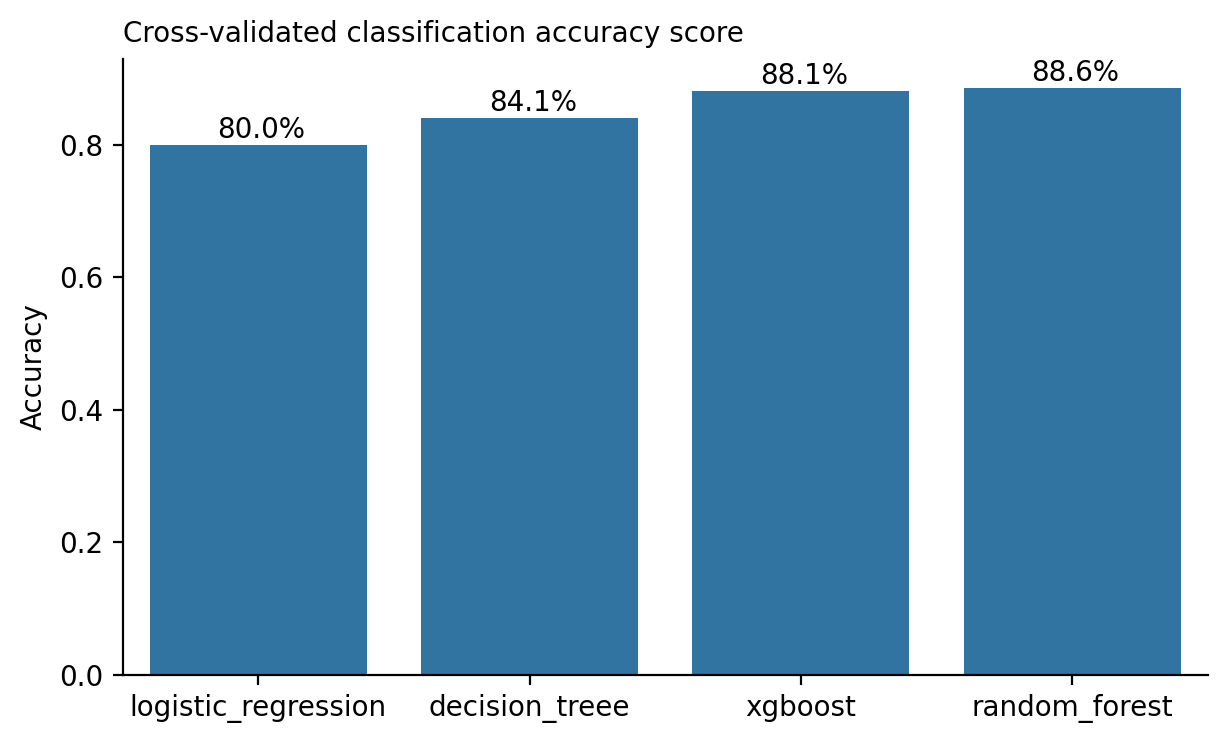

In [48]:
# Plot average CV accuracy
avg_down_accuracy = down_accuracy.groupby("model")["accuracy"].mean().reset_index()
avg_down_accuracy["accuracy"] = avg_down_accuracy["accuracy"] / 100.0
avg_down_accuracy.sort_values("accuracy", inplace=True)

plt.figure(figsize=(7, 4))
sns.barplot(data=avg_down_accuracy, x="model", y="accuracy", color="tab:blue")
plt.title("Cross-validated classification accuracy score (Downsampled dataset)", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.ylabel("Accuracy")
plt.xlabel("")
for i, val in enumerate(avg_down_accuracy["accuracy"]):
    plt.text(i-0.15, val+0.01, f"{val:.1%}", fontsize=10)

plt.show()